In [17]:
# Custom libraries
from datascienceutils import plotter
from datascienceutils import analyze

# Standard libraries
import json
%matplotlib inline
import datetime
import numpy as np
import pandas as pd
import random

from sklearn import cross_validation
from sklearn import metrics

from bokeh.plotting import figure, show, output_file, output_notebook, ColumnDataSource
from bokeh.charts import Histogram
import bokeh
output_notebook(bokeh.resources.INLINE)

from sqlalchemy import create_engine

Loading BokehJS ...

## Data Source/Background:  We have data about measurements of flowers from species belonging to a particular genus.()

In [18]:
headers = ['SepalLengthCm', 'SepalWidthCm', 'PetalLengthCm', 'PetalWidthCm',
       'Species']

irisDf = pd.read_csv('http://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data', names=headers)


## Ok data loaded now let's assume we know nothing of patterns in this data and take a peek

In [19]:
irisDf.describe()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


In [20]:
irisDf.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


## Ok we have 4 numerical columns and a categorical column. 
## Can we see any correlation among the numericals?

In [21]:
irisDf.corr()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
SepalLengthCm,1.000000,-0.109369,0.871754,0.817954
SepalWidthCm,-0.109369,1.000000,-0.420516,-0.356544
PetalLengthCm,0.871754,-0.420516,1.000000,0.962757
PetalWidthCm,0.817954,-0.356544,0.962757,1.000000


## Hmm.. We have a few +ve correlations  like (PetalLength vs SepalLength, PetalWidth vs PetalLength etc..)

The intra petal and intra sepal make sense. As the size of the flower will correspond to petal length and petal width. (same for sepal length and width). 

However the PetalLength vs SepalLength is new.. Come to think of it, what counts as petal and what is a sepal??

[Petal](https://en.wikipedia.org/wiki/Petal)
[Sepal](https://en.wikipedia.org/wiki/Sepal)

## That makes sense since sepal is a leaf-like part that supports the flower, if the flower is bigger the support also has to be bigger. Let's move on to see more.

In [22]:
analyze.correlation_analyze(irisDf, exclude_columns='Id', 
                                categories=['Species'], 
                                measure=['SepalLengthCm','SepalWidthCm',
                                           'PetalLengthCm', 'PetalWidthCm'])

# Correlation btw Numerical Columns


# Pandas correlation coefficients matrix
               SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
SepalLengthCm       1.000000     -0.109369       0.871754      0.817954
SepalWidthCm       -0.109369      1.000000      -0.420516     -0.356544
PetalLengthCm       0.871754     -0.420516       1.000000      0.962757
PetalWidthCm        0.817954     -0.356544       0.962757      1.000000
# Pandas co-variance coefficients matrix
               SepalLengthCm  SepalWidthCm  PetalLengthCm  PetalWidthCm
SepalLengthCm       0.685694     -0.039268       1.273682      0.516904
SepalWidthCm       -0.039268      0.188004      -0.321713     -0.117981
PetalLengthCm       1.273682     -0.321713       3.113179      1.296387
PetalWidthCm        0.516904     -0.117981       1.296387      0.582414


## That petallength vs sepallength looks interesting.. they correlate linearly after a certain threshold, but not before that. Might be species mixed up data,  but it does make sense that the sepals serving only a support role might not grow till a threshold level is reached for the flower size.

## The petal Length vs SepalWidth suggests there are two species atleast.. same from PetalWidth vs PetalLength 

## Let's look at the distributions


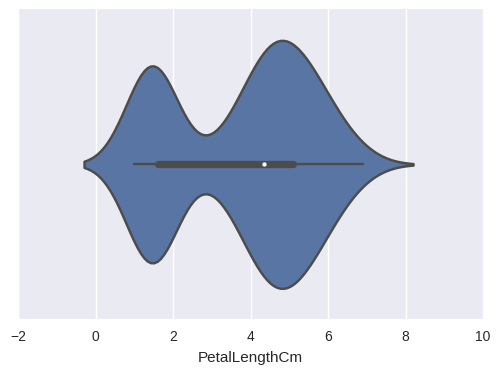

In [23]:
analyze.dist_analyze(irisDf, 'PetalLengthCm')

## Aha.. There you go there's clearly atleast two different clusters/species based on PetalLength alone.  Let's look at SepalWidth next

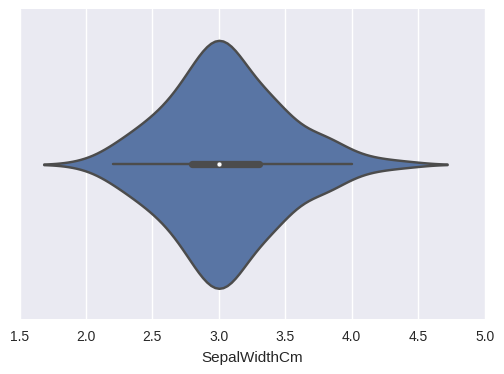

In [24]:
analyze.dist_analyze(irisDf, 'SepalWidthCm')

## Hmm. how about sepalLength

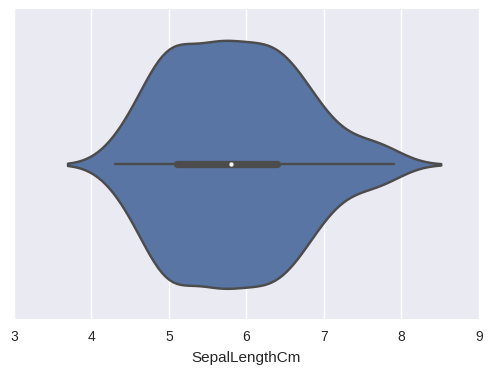

In [25]:
analyze.dist_analyze(irisDf, 'SepalLengthCm')

## So we can't distinguish the clusters/Species by Sepal size.  Let's do some cluster analysis. 

In [26]:
## First see how many species are labeled
irisDf.Species.unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

For clusters = 2 The average silhouette_score is : 0.680813620294


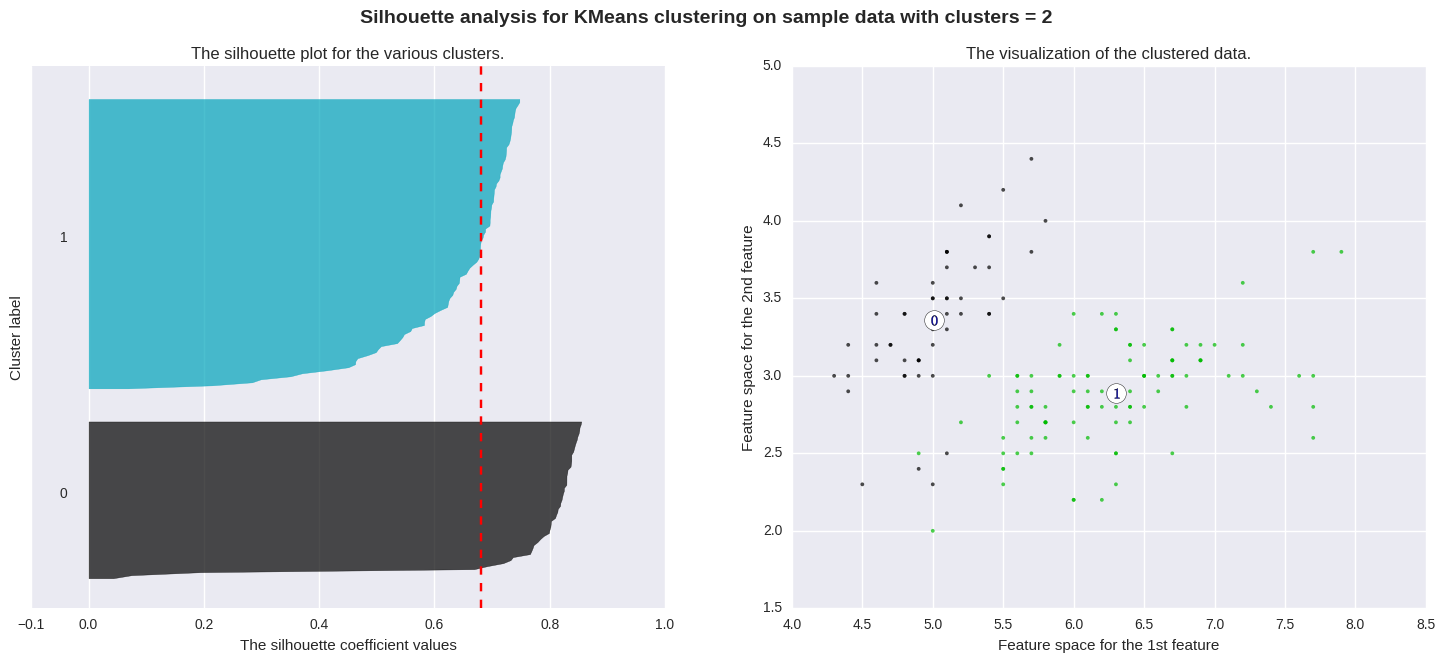

For clusters = 4 The average silhouette_score is : 0.49782569011


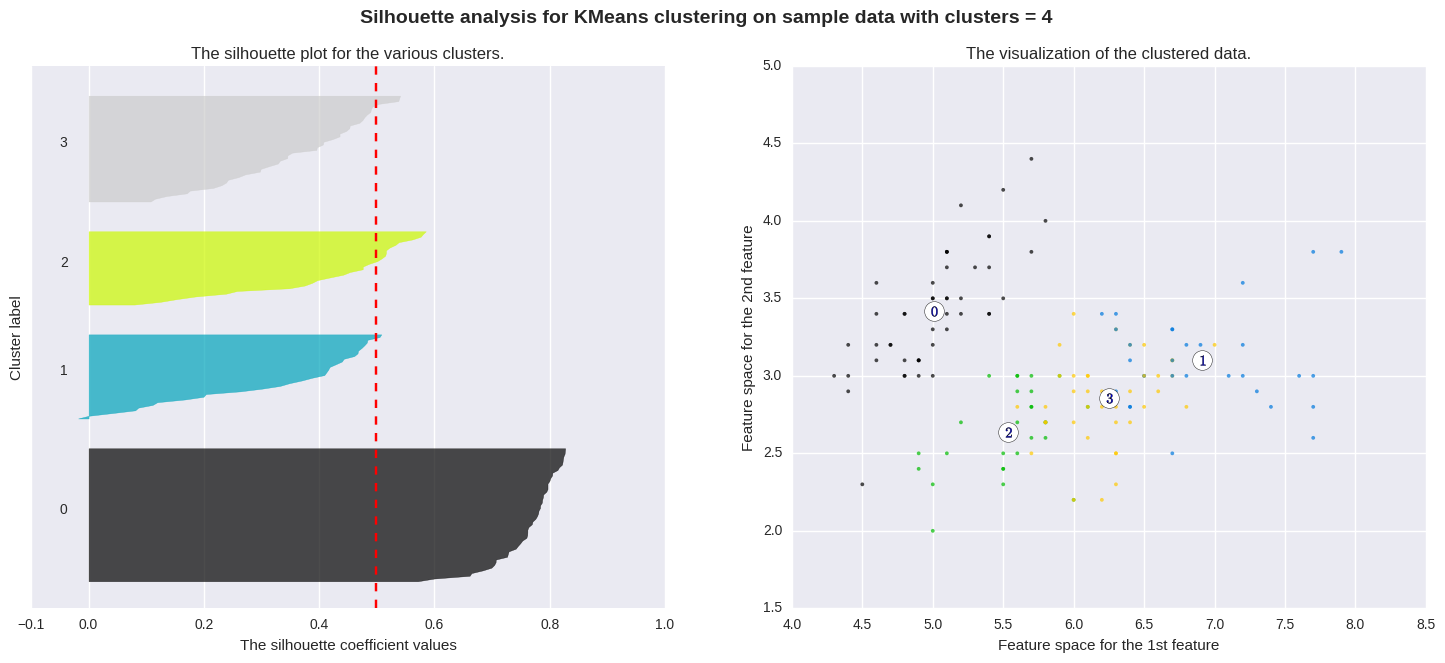

For clusters = 6 The average silhouette_score is : 0.371218050546


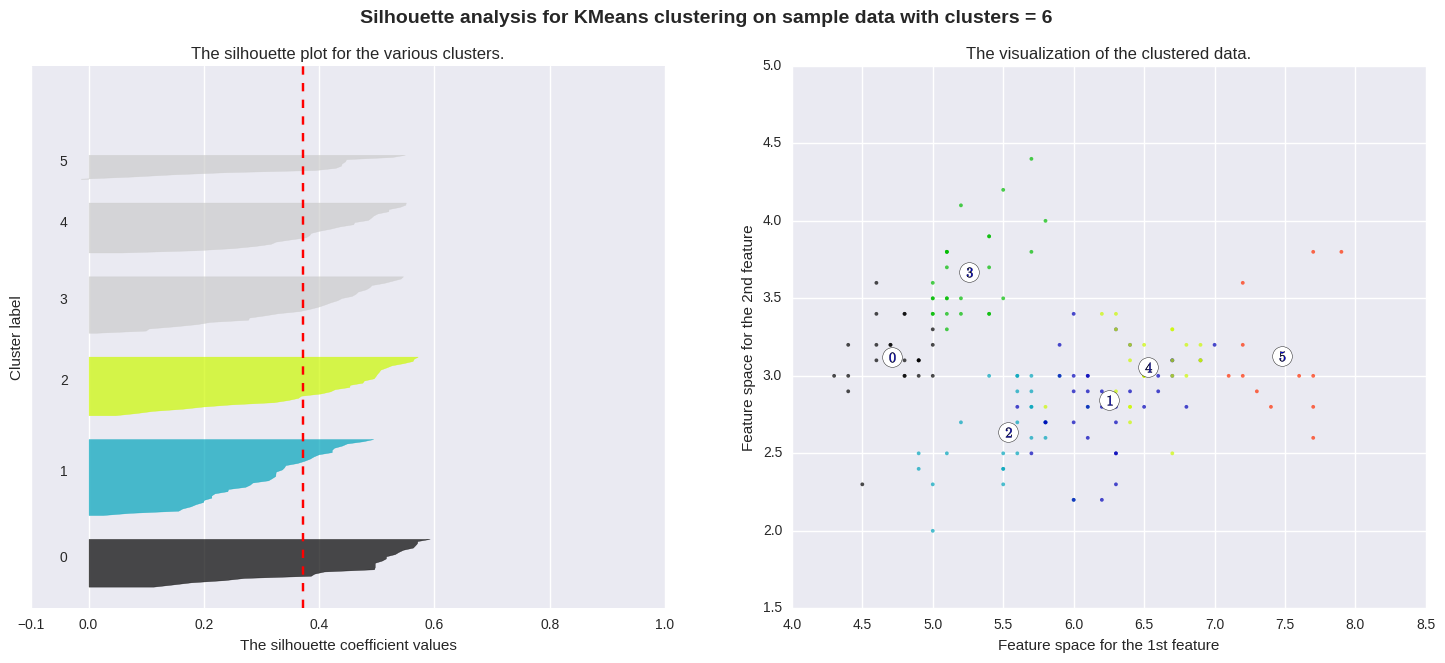

In [27]:
## It seems 3.. Let's see if our algorithms can find it. 
tempDf = irisDf.copy(deep=True)
tempDf.drop(['Species'], 1, inplace=True)
analyze.silhouette_analyze(tempDf, cluster_type='KMeans')

   ## Hmm.. That's interesting... The silhouette score keeps falling even after clustering with 4 clusters. So it is clear we should finalize a cluster number < 4
   ## From the scatter plot both 2 and 4 clusters look believable let's try again with 3 clusters.


For clusters = 2 The average silhouette_score is : 0.194528521515


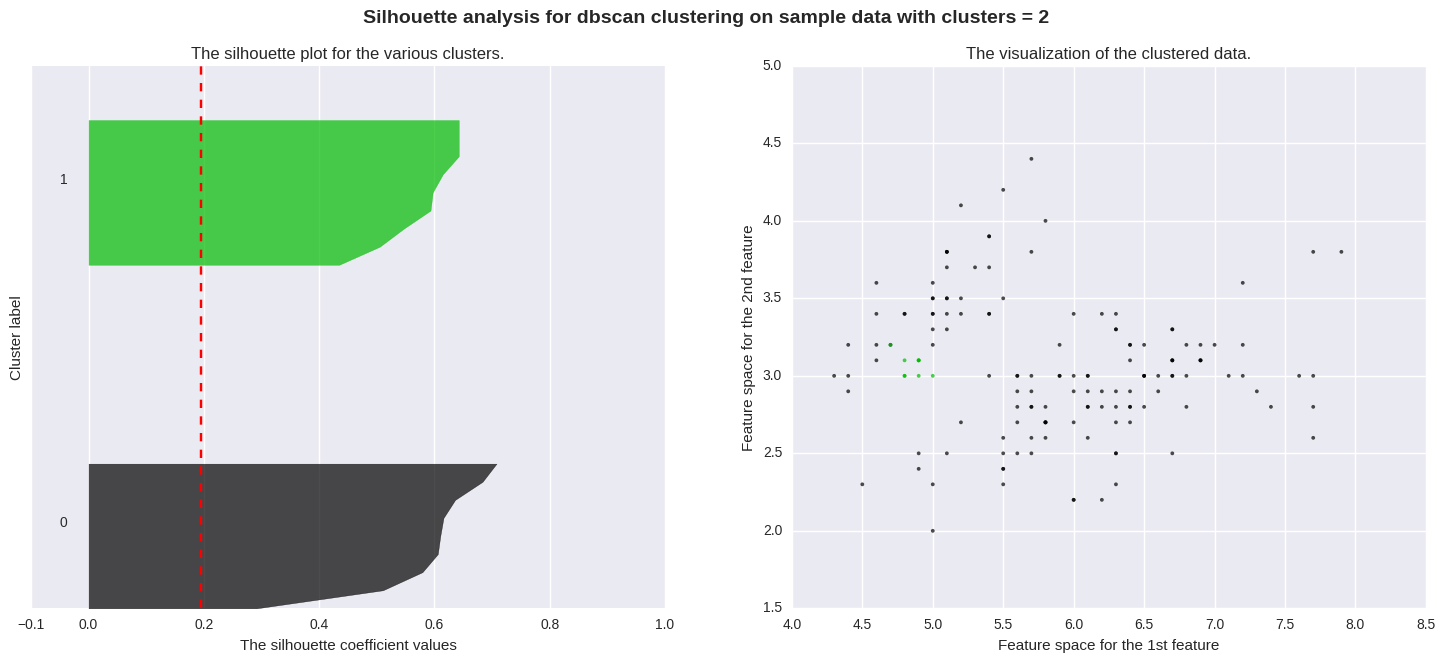

For clusters = 3 The average silhouette_score is : 0.194528521515


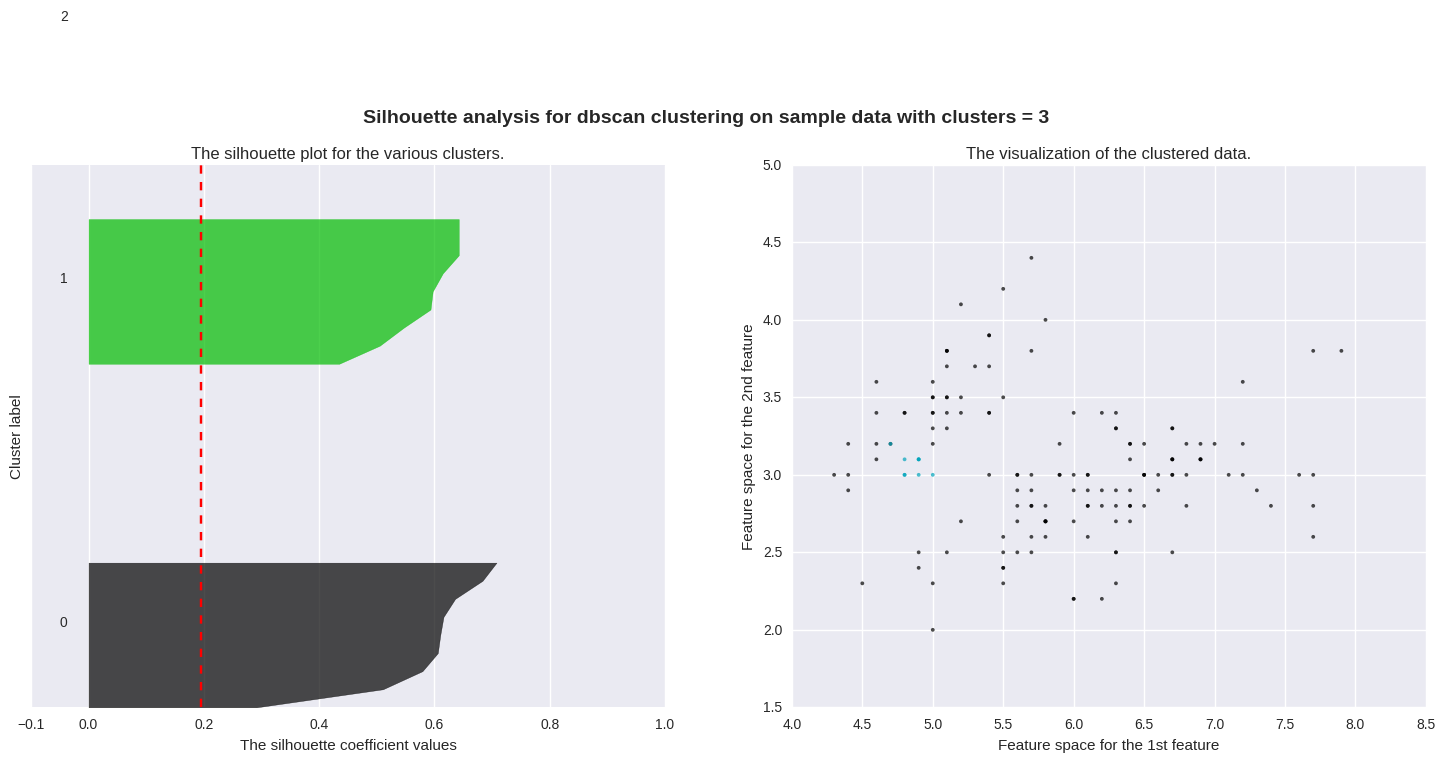

In [28]:
analyze.silhouette_analyze(tempDf, cluster_type='dbscan', n_clusters=range(2,4))

For clusters = 2 The average silhouette_score is : 0.541135625298


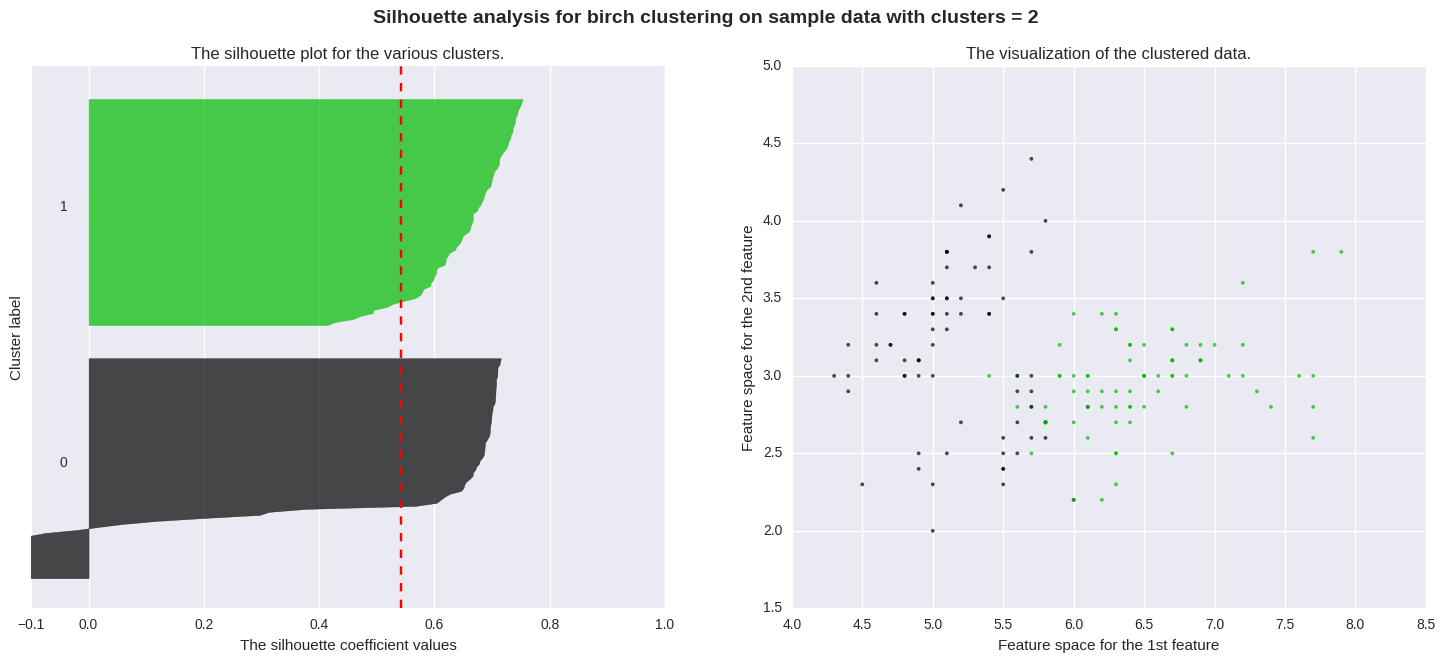

For clusters = 3 The average silhouette_score is : 0.501699257107


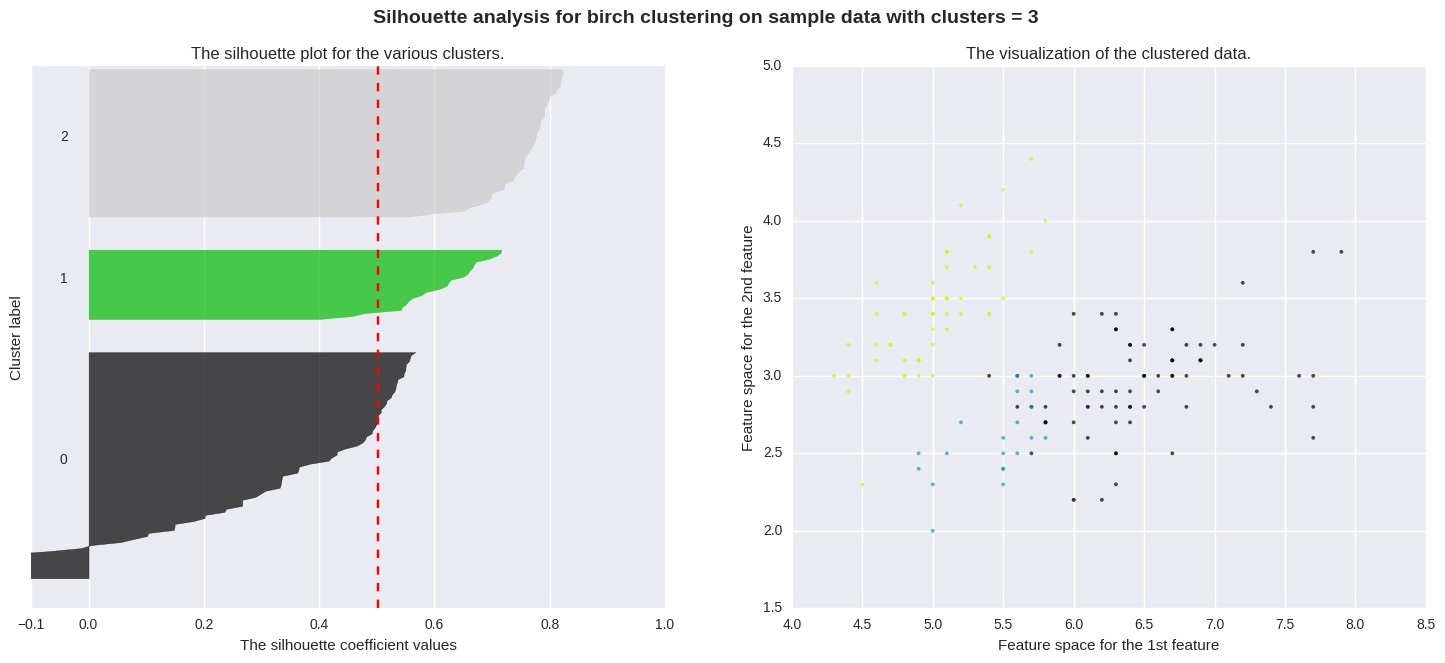

In [35]:
analyze.silhouette_analyze(tempDf, cluster_type='birch', n_clusters=range(2,4))

## Purely by the algorithm and silhouette score(higher ==> better clustering.), we think there should be 2 clusters. However based on the Species labels there are 3-clusters.

 So we'll have to conclude either 
        * uneven distribution of data samples within clusters
        * algorithmic issues/inefficiency (try dbscan or other clustering) 
        * Two of the species are simply too close in the flower based  measures, but different by other plant characteristics so not captured in this data

In [29]:
# Testing the first case
irisDf.groupby('Species').count()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm
Species,,,,
Iris-setosa,50,50,50,50
Iris-versicolor,50,50,50,50
Iris-virginica,50,50,50,50


For clusters = 2 The average silhouette_score is : 0.194528521515


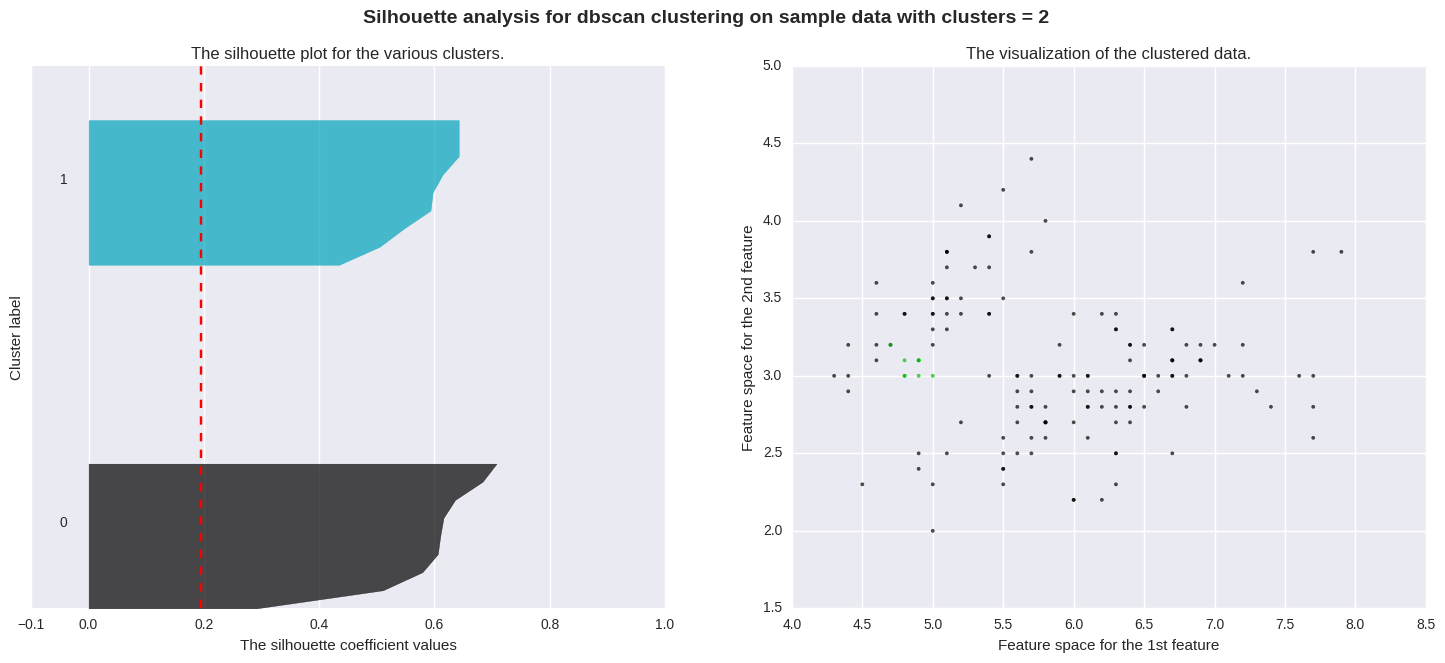

For clusters = 3 The average silhouette_score is : 0.194528521515


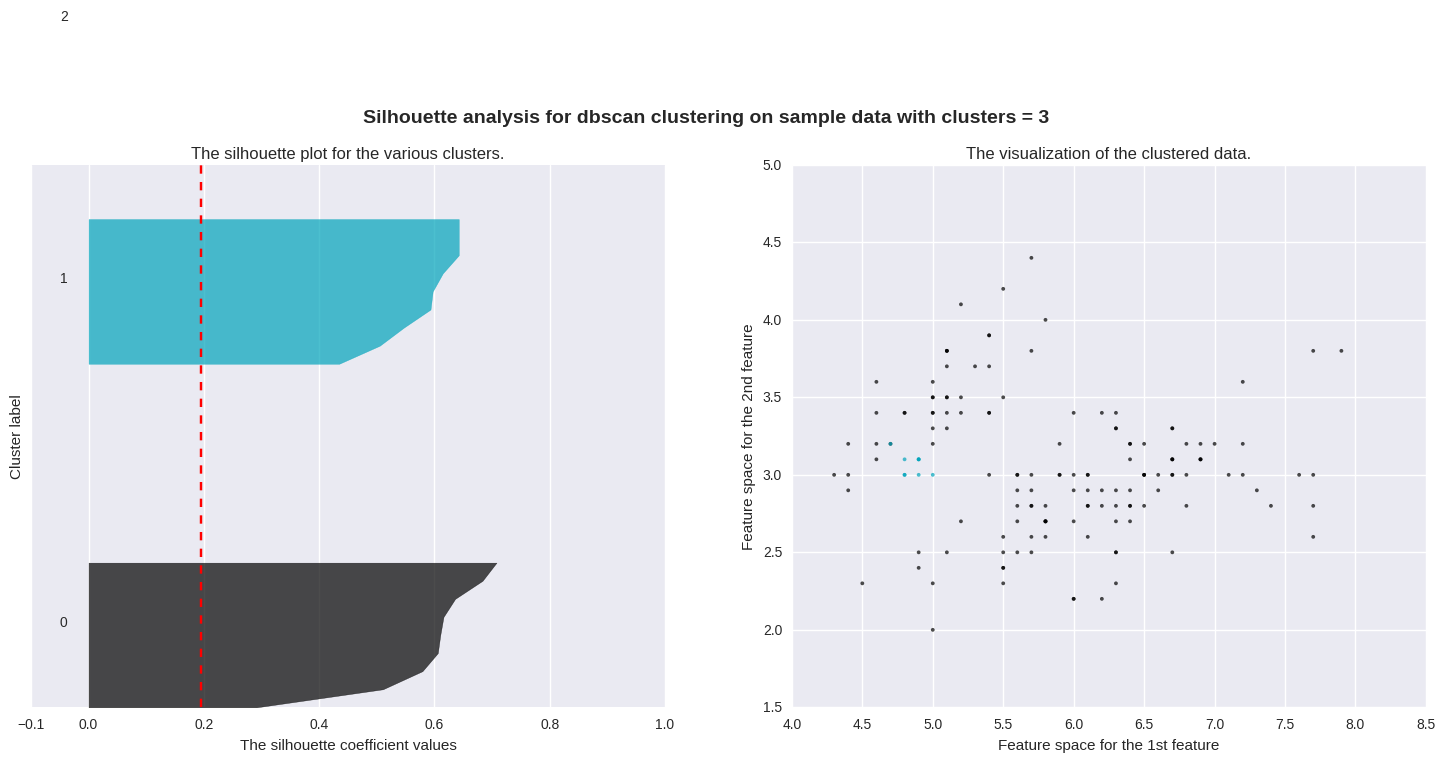

For clusters = 4 The average silhouette_score is : 0.194528521515


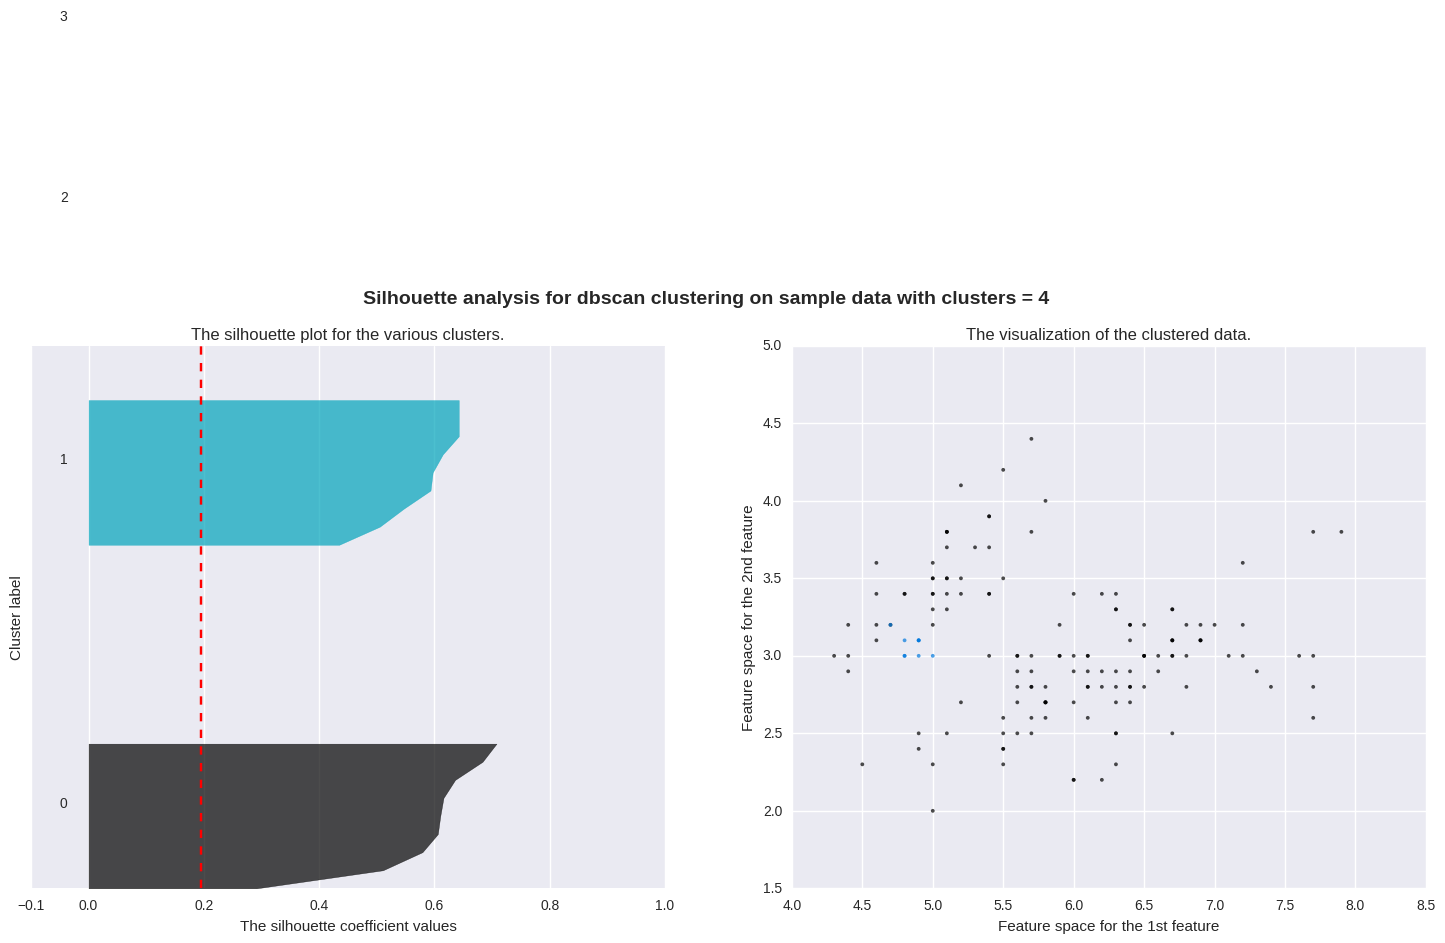

In [34]:
## Spectral clustering can other 
analyze.silhouette_analyze(tempDf, cluster_type='dbscan', n_clusters=range(2,5))

/home/anand/anaconda3/envs/analytics/lib/python3.5/site-packages/sklearn/manifold/spectral_embedding_.py:229: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


For clusters = 2 The average silhouette_score is : 0.686393054345


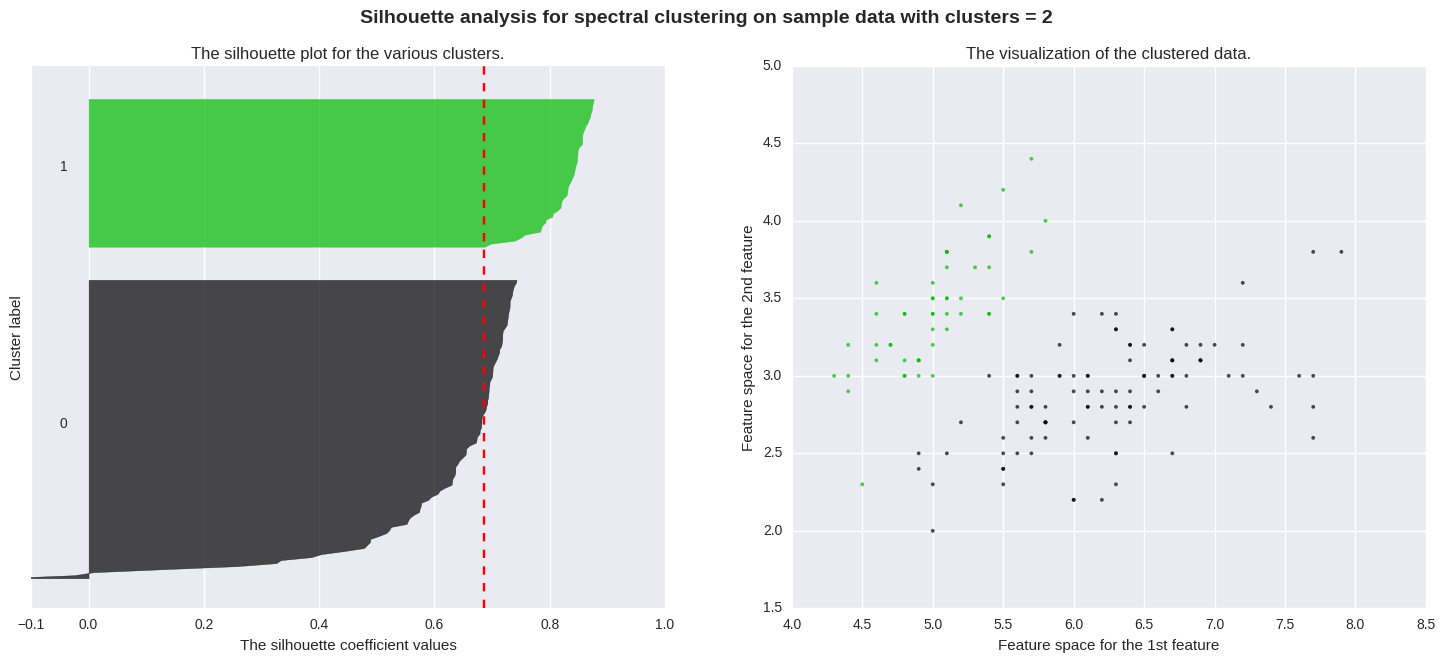

For clusters = 3 The average silhouette_score is : 0.553934389855


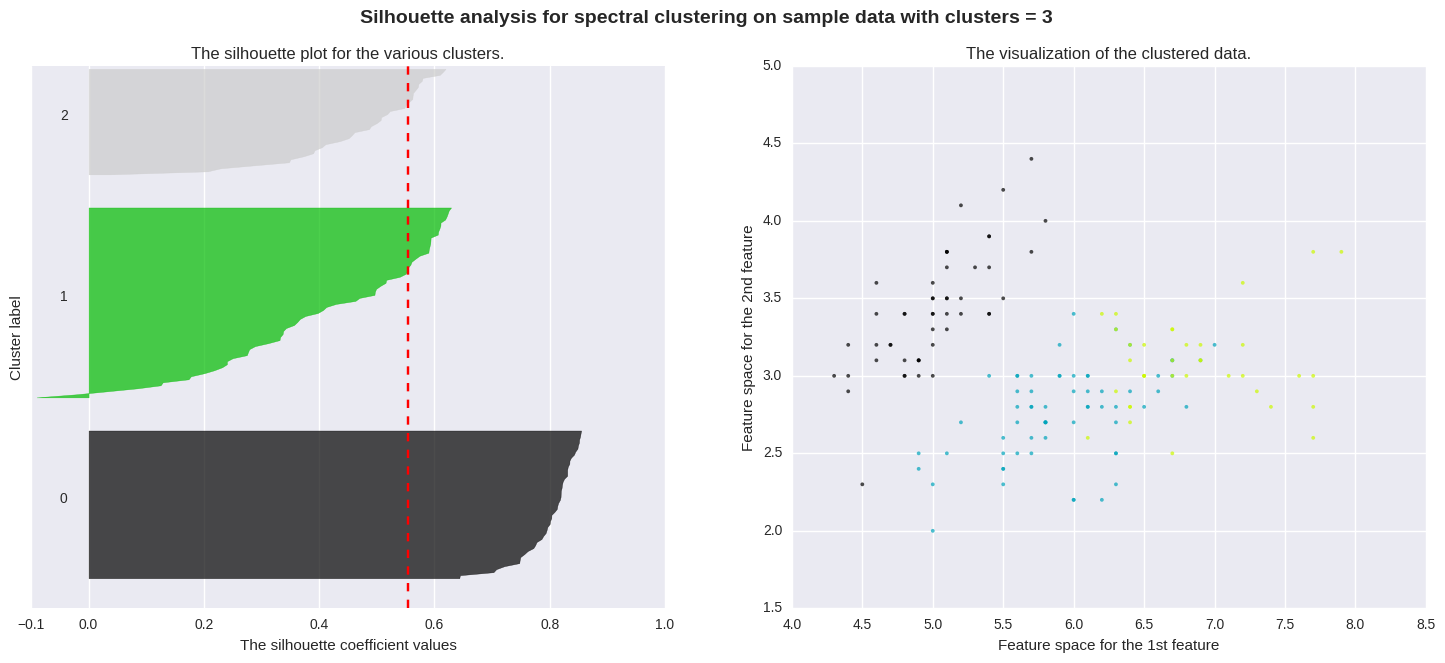

In [31]:
# Testing the second case
analyze.silhouette_analyze(tempDf, cluster_type='spectral', n_clusters=range(2,4))

## Now let's return to the Regression we saw between PetalLength vs SepalLength

In [32]:
analyze.regression_analyze(irisDf, 'SepalLengthCm', 'PetalLengthCm')

/home/anand/anaconda3/envs/analytics/lib/python3.5/site-packages/datascienceutils-1.0.29-py3.5.egg/datascienceutils/predictiveModels.py:114: FutureWarning: reshape is deprecated and will raise in a subsequent release. Please use .values.reshape(...) instead


Regression Score
0.759955310778


## Ok there's a clear distinction between the two clusters and in one of them we can simply predict PetalLength based on SepalLength 

## Unfortunately, this is one of those insights/patterns that's not likely to be useful for this data set. 

## I mean who wants to predict a flower's sepal length based on it's petal Length?? I mean, we can just measure the sepalLength too.. 

## Ah.. perhaps if we are a species millions of times smaller than the flower and measuring is of very highly costly...  

## Aka... if these were galaxies instead of flowers then predicion of Sepal length would be useful.